In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Solution to Exercise 6: Non-linear gravity inversion

Due to karstification processes in the subsurface, large cavities can form, which may ultimately collapse posing substantial risks to human life and infrastructures (See [this example](https://www.independent.co.uk/news/science/sinkholes-what-are-they-how-do-they-form-and-why-are-we-seeing-so-many-9136235.html) from Guatemala in 2010). Fortunately, cavities represent large density contrasts, such that they can be detected using gravimetric measurements (measuring local anomalies in gravitational acceleration). The dataset contains 50 equally spaced readings (given in mGal) along a profile from -50 to 50 meters. The anomaly is expected within the center of the profile. The analytical solution for a spheric anomaly in the subsurface is given by:

$$
\Delta\mathrm{g}_{\mathrm{z}}=\mathrm{G} \frac{4}{3} \pi \mathrm{R}^{3} \Delta \rho \frac{\mathrm{z}}{\left(\mathrm{x}^{2}+\mathrm{z}^{2}\right)^{3 / 2}}
$$

where $\Delta\mathrm{g}_{\mathrm{z}}$ is the vertical component of the gravimetric anomaly in m/s$^2$, $G$ is the gravitational constant (6.6743 $\times 10^{-11}$ m$^3$/(kg $\times$ s$^2$)), $R$ is the radius of the sphere in meter, $\Delta \rho$ is the density contrast between the anomaly and the surrounding rock in kg/m$^3$, $z$ is the depth of the center of the sphere, and $x$ is the location along the profile.
Both $x$ and $z$ are in meters.

We have the following a priori information:

- The surrounding rock is expected to have a density of 3000 kg per cubic meters.
- A basaltic bedrock is located at 50 meters depth.
- Maximum radii of anomalies within the same region were measured to be 25 meters.


Estimate the radius and the depth of the cavity using a grid-search procedure. Visualize the misfit (prediction error) as a function of both parameters. Is there a global minimum?

# Loading and visualizing the measurements


First the measured data is loaded

In [2]:
dobs = np.loadtxt("data.dat")

Take a first look at your gravity data by plotting it.

Text(0, 0.5, 'Gravity anomaly (mGal)')

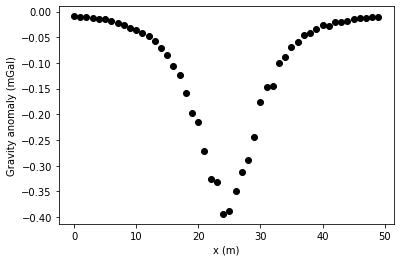

In [3]:
plt.plot(dobs, "ko")
plt.xlabel("x (m)")
plt.ylabel("Gravity anomaly (mGal)")

Now define your auxiliary variables, such as measurement locations and all the constants you need, including your expected density contrast. Put the equation above in a Python function. This is your forward operator (i.e., G is a function now, not a matrix anymore!). Which parameters should the forward operator depend on? **Take care that your forward operator and the measured data have the same units!**

In [4]:
# Define measurement positions, rho, G, and delta_gz
x = np.linspace(-50,50,50)
density = -3000 # cavity = decrease in density
G = 6.6743e-11 # gravitational constant

def grav(R, z):
    """Formula from the exercise sheet as a function for later reuse."""
    gz = 4/3 * np.pi * R**3 * density * G * z / (x**2 + z**2)**(3/2)
    gz *= 1e5 # unit conversion
    return gz

The forward operator should depend on the anomaly radius and depth, since these are the parameters we're inverting for.

# Trying some parameters and visualizing the model response

Now we can test different model hypotheses and simulate their response. Start with a constant radius and try different anomaly depths.
Visualize the different models and their response in two separate plots. Some plotting advice:

You can create several subplots by using fig, ax = [plt.subplots()](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.subplots.html). 

To get the same color for the same model in both plots you can store the first one like: line, = ax.plot(x, y). By using color=line.get_color() in the second plot's arguments you ensure your model has the same color as the corresponding resonse.

*Plotting Hints*  
* You can create circular objects using [plt.Circle()](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.patches.Circle.html?highlight=circle#matplotlib.patches.Circle) 
* and add them to a subplot via [ax.add_artist()](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.add_artist.html?highlight=add_artist#matplotlib.axes.Axes.add_artist).  

* In order to keep the aspect ratio equal you can use [ax.set_aspect()](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.set_aspect.html) 

Text(0.5, 0, 'x (m)')

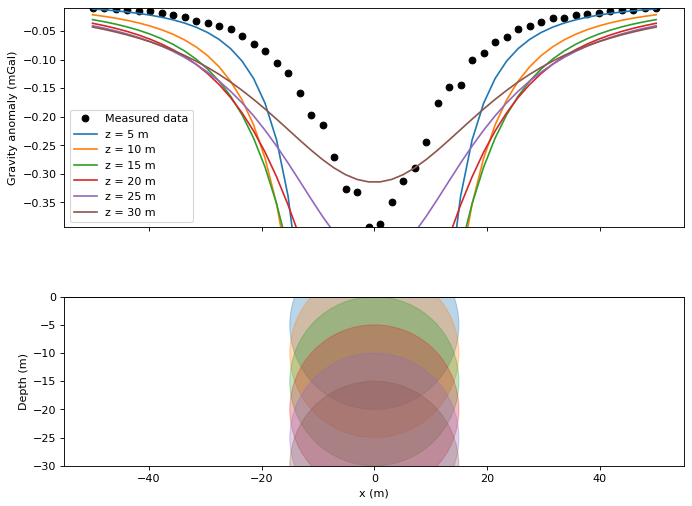

In [5]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True, dpi=80)

ax1.plot(x, dobs, "ko", label="Measured data")

Rs = 15
zs = [5,10,15,20,25,30]

for z in zs:
    dpre = grav(Rs, z)
    line, = ax1.plot(x, dpre, label="z = %d m" % z)

    circle = plt.Circle((0, -z), Rs, alpha=0.3, color=line.get_color())
    ax2.add_artist(circle)

ax1.set_ylim(dobs.min(), dobs.max())
ax1.legend()

ax2.axhline(0, color="k")
ax2.set_ylim(-np.max(zs),0)
ax2.set_aspect("equal")
ax1.set_ylabel("Gravity anomaly (mGal)")
ax2.set_ylabel("Depth (m)")
ax2.set_xlabel("x (m)")

# Grid search (brute force) procedure

Now that the forward operator is working the full grid search can commence.

Think of useful value ranges to test for each parameter, which you can then create using [np.linspace](https://numpy.org/doc/stable/reference/generated/numpy.linspace.html?highlight=linspace#numpy.linspace). Check the given a priori information above.

Given a set of parameter ranges, the [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) function can create two grids in matrix form that reflect the possible parameter combinations. This is useful to determine the corresponding parameters once you have found an optimum. 

To find an optimum you also need to create an objective function that returns the norm of the prediction error, as well as an appropriately shaped array to store the objective function evaluations. The [argmin](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html?highlight=argmin#numpy.argmin) function helps you find the index of the optimum.   
*Hint: you can use [np.unravel_index()](https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html) to get the coordinates of the optimal parameters*

To loop over a set of items while also getting their indices returned, use the [enumerate](https://www.programiz.com/python-programming/methods/built-in/enumerate) function

In [6]:
size=250
radii = np.linspace(1,30,size)
depth = np.linspace(1,50,size)

obj = np.zeros((size, size))
X, Y = np.meshgrid(radii, depth)

def objective(params):
    R, d = params[0], params[1]
    return np.sqrt(np.mean((dobs - grav(R, d))**2))
    
for i, R in enumerate(radii):
    for j, d in enumerate(depth):
        obj[j, i] = objective((R, d))
 
i, j = np.where(obj == obj.min())
rad_opt, depth_opt = X[i,j],Y[i,j]

# Visualizing the prediction error for all combinations of R and z

You can now plot the grid search results. Besides the optimum you should also have a matrix with the norm of prediction errors, which you can plot [discretely](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html) or [continuously](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.axes.Axes.pcolor.html?highlight=pcolor#matplotlib.axes.Axes.pcolor). Plot the minimum into the parameter space and highlight the corresponding parameters by drawing [horizontal](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.hlines.html?highlight=hline#matplotlib.pyplot.hlines) and [vertical](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.vlines.html#matplotlib.pyplot.vlines) lines from the minimum toward the axes.

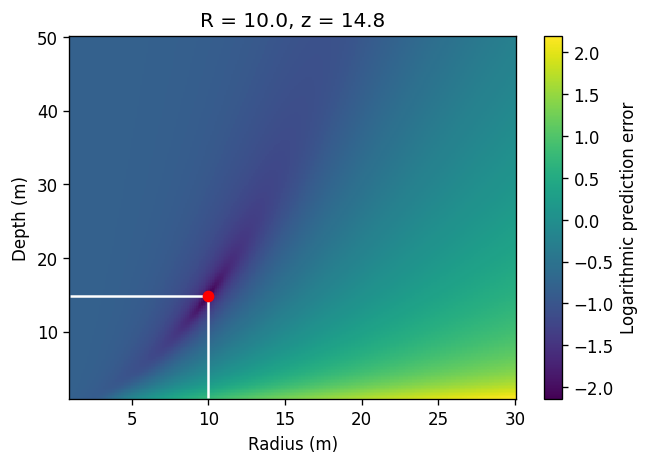

In [7]:
plt.figure(dpi=120)
plt.pcolor(X, Y, np.log10(obj), shading="auto")
plt.plot(rad_opt, depth_opt, "ro")
plt.vlines(rad_opt, 1, depth_opt, "w")
plt.hlines(depth_opt, 1, rad_opt, "w")
plt.title("R = %.1f, z = %.1f" % (rad_opt, depth_opt))
plt.xlabel("Radius (m)")
plt.ylabel("Depth (m)")
plt.colorbar(label="Logarithmic prediction error")

# Visualizing final result (global minimum)

Now visualize the model corresponding to the optimum. Plot the response and the model into separate coorinate systems like you did above.

Text(0.5, 0, 'x (m)')

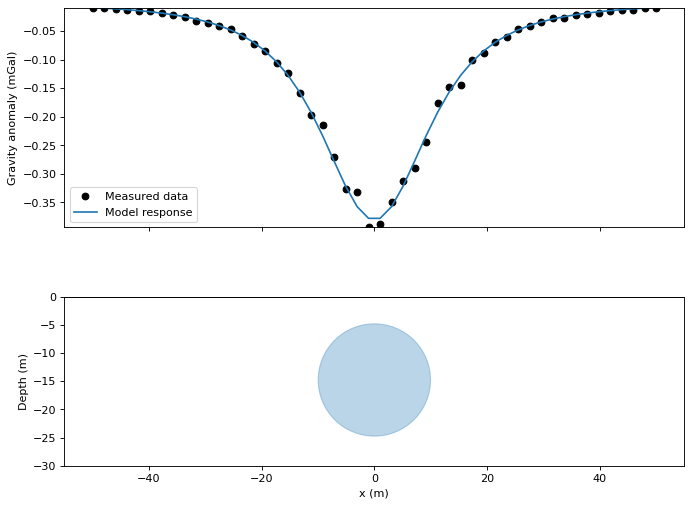

In [8]:
dpre = grav(rad_opt, depth_opt)

fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True, dpi=80)

ax1.plot(x, dobs, "ko", label="Measured data")
line, = ax1.plot(x, dpre, label="Model response")
circle = plt.Circle((0, -depth_opt), rad_opt, alpha=0.3, color=line.get_color())
ax2.add_artist(circle)

ax1.set_ylim(dobs.min(), dobs.max())
ax1.legend()

ax2.axhline(0, color="k")
ax2.set_ylim(-np.max(zs),0)
ax2.set_aspect("equal")
ax1.set_ylabel("Gravity anomaly (mGal)")
ax2.set_ylabel("Depth (m)")
ax2.set_xlabel("x (m)")

--- 
## Bonus

The grid search procedure above is also available in the `scipy.optimize` package, and has direct parallelization of the different function calls: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.brute.html
Actually all approaches discussed in the lecture on non-linear optimization are in the scipy optimize package. The [`minimize`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html) function provides a unified interface to them, which we can use here to solve our problem more efficiently. Try it out!

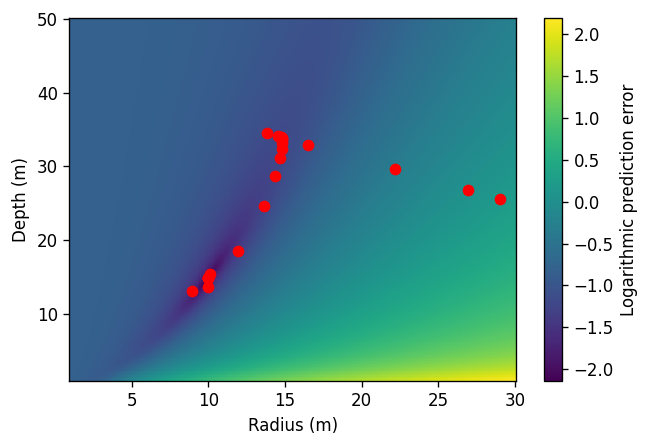

In [9]:
from scipy.optimize import minimize

plt.figure(dpi=120)
plt.pcolor(X, Y, np.log10(obj), shading="auto")
plt.xlabel("Radius (m)")
plt.ylabel("Depth (m)")
plt.colorbar(label="Logarithmic prediction error")

def plot(A):
    plt.plot(A[0], A[1], "ro")

start = [30,25]
result = minimize(objective, start, callback=plot)

#### Note that the method above uses gradient information (how does the prediction error change with a change in the parameters), which is significantly faster. The function is only evaluated at the red dots and not over the entire model space.